In [118]:
from collections import defaultdict
import numpy as np
import math
from functools import cmp_to_key


class UnionFind:
    def __init__(self, n):
        self.parent = [i for i in range(n)]

    def find(self, p):
        root = p

        while root != self.parent[root]:
            root = self.parent[root]

        while p != self.parent[p]:
            tmp = self.parent[p]
            self.parent[p] = root
            p = tmp
        return root

    def union(self, p, q):
        p_id = self.find(p)
        q_id = self.find(q)
        if p_id == q_id:
            return 
        self.parent[p_id] = q_id

def get_rect_points(text_boxes):
    text_boxes = np.array(text_boxes)
    x1 = np.min(text_boxes[:, :, 0])
    y1 = np.min(text_boxes[:, :, 1])
    x2 = np.max(text_boxes[:, :, 0])
    y2 = np.max(text_boxes[:, :, 1])

    return [[x1, y1],[x2, y1], [x2, y2],[x1, y2]]

def get_slope(rect):
    x1, x2, _, _ = rect
    if x2[0]-x1[0] == 0:
        return None 

    return (x2[1] - x1[1]) / (x2[0] - x1[0])

def get_char_size(rect):
    x1, x2, x3, x4 = rect
    height = (abs(x4[1]-x1[1]) + abs(x3[1]-x2[1])) / 2
    return height

def get_rect_center(rect):
    x1, _, x3, _ = rect
    return [(x1[0]+x3[0])/2, (x1[1]+x3[1])/2]

def rotate_point(angle, valuex, valuey, pointx, pointy, direction="S"):
    valuex = np.array(valuex)
    valuey = np.array(valuey)
    if direction == "S":
        Rotatex = (valuex-pointx)*math.cos(angle) + (valuey-pointy)*math.sin(angle) + pointx
        Rotatey = (valuey-pointy)*math.cos(angle) - (valuex-pointx)*math.sin(angle) + pointy
    else:
        Rotatex = (valuex-pointx)*math.cos(angle) - (valuey-pointy)*math.sin(angle) + pointx
        Rotatey = (valuex-pointx)*math.sin(angle) + (valuey-pointy)*math.cos(angle) + pointy
    return Rotatex, Rotatey

def rotate_rect(rect, angle, direction="S"):
    rotated_rect = []
    center_x, center_y = get_rect_center(rect)
    for x, y in rect:
        rotated_rect.append(rotate_point(angle, x, y, center_x, center_y, direction))
    
    return rotated_rect

def overlap(min1, max1, min2, max2):
    return max(0, min(max1, max2) - max(min1, min2))

def calc_overlap_for_Yaxis(rect1, rect2):
    '''
        calculate overlap in Y-axis
    '''
    rect1 = np.array(rect1)
    rect2 = np.array(rect2)
    y1_min, y1_max = np.min(rect1[:, 1]), np.max(rect1[:, 1])
    y2_min, y2_max = np.min(rect2[:, 1]), np.max(rect2[:, 1])
    height1, height2 = y1_max-y1_min, y2_max-y2_min
    Yaxis_overlap = overlap(y1_min, y1_max, y2_min, y2_max) / min(height1, height2)

    return Yaxis_overlap

def calc_overlap_for_Xaxis(rect1, rect2):
    '''
        calculate overlap in X-axis
    '''
    rect1 = np.array(rect1)
    rect2 = np.array(rect2)
    x1_min, x1_max = np.min(rect1[:, 0]), np.max(rect1[:, 0])
    x2_min, x2_max = np.min(rect2[:, 0]), np.max(rect2[:, 0])
    width1, width2 = x1_max-x1_min, x2_max-x2_min
    Xaxis_overlap = overlap(x1_min, x1_max, x2_min, x2_max) / min(width1, width2)
    
    return Xaxis_overlap

def judge_two_rects(rect1, rect2, text1, text2, slope_thres, char_thres, overlap_thres, y_dis_thres):
    '''
        judge whether two rects can be merged
        1.倾斜角度
        2.字体大小相似 (the height of char)
        3.垂直或水平的重合度
    '''
#     print("---------------------------")
#     print("text:", text1, text2)
    # the slope of two rects
    slope1 = get_slope(rect1)
    slope2 = get_slope(rect2)
#     print("slope:", slope1, slope2)
    if slope1 == None or slope2 == None:
        return False
    if abs(slope1 - slope2) > slope_thres:
        return False
    
    # the char size
    char_size1 = get_char_size(rect1)
    char_size2 = get_char_size(rect2)
#     print("char_size:", char_size1, char_size2)
    if abs(char_size1 - char_size2)/max(abs(char_size1), abs(char_size2)) > char_thres:
        return False
    
    # overlap
    average_k = (get_slope(rect1)+get_slope(rect2)) / 2
    angle = np.arctan(average_k)
    rotated_rect1 = rotate_rect(rect1, angle, direction="S")
    rotated_rect2 = rotate_rect(rect2, angle, direction="S")
    x_overlap = calc_overlap_for_Xaxis(rotated_rect1, rotated_rect2)
    y_overlap = calc_overlap_for_Yaxis(rotated_rect1, rotated_rect2)
#     print("dist:", dist, (1+dis_thres) * side_len)
    if x_overlap < overlap_thres and y_overlap < overlap_thres:
        return False
    
    center1 = get_rect_center(rect1)
    center2 = get_rect_center(rect2)
#     print("y_dist:", (center1[1]-center2[1])/min(char_size1, char_size2))
    if abs(center1[1]-center2[1])/((char_size1+char_size2)/2) > y_dis_thres:
        return False

    return True

def rect_cmp(rect1, rect2):
    rect1, rect2 = rect1[0], rect2[0]
    char_size = min(get_char_size(rect1), get_char_size(rect2))
    center1 = get_rect_center(rect1)
    center2 = get_rect_center(rect2)
    if abs(center1[1]-center2[1])/char_size > 0.3:
        return center1[1] < center2[1]
    
    return center1[0] < center2[0]    
    
def merge_rects(rects, texts):
    '''
        merge a list of rects into one
    '''
    # calculate average angle
    average_k = 0
    for rect in rects:
        average_k += get_slope(rect)
    average_k /= len(rects)
    angle = np.arctan(average_k)
    rotated_rects = []
    for rect in rects:
        rotated_rects.append(rotate_rect(rect, angle, direction="S"))
    sorted_rects = sorted(list(zip(rotated_rects, texts)), key=cmp_to_key(rect_cmp),reverse=True)
    new_text = " ".join([rect[1] for rect in sorted_rects])
    new_rect = get_rect_points(rects)
    new_rect = rotate_rect(new_rect, angle, direction="N")

    return new_rect, new_text
    
def boxes_connect(rects, texts, slope_thres, char_thres, dis_thres, y_dis_thres):
    n = len(rects)
    uf = UnionFind(n)
    for i in range(n):
        for j in range(i+1, n):
            if judge_two_rects(rects[i], rects[j], texts[i], texts[j], slope_thres, char_thres, dis_thres, y_dis_thres):
#                 print(i, j)
#                 print(texts[i], texts[j])
                uf.union(i, j)

    connected_idx = defaultdict(list)
    for i in range(n):
        connected_idx[uf.find(i)].append(i)
    
    connected_boxes = list(connected_idx.values())
#     print("connected_boxes:", connected_boxes)
    new_rects, new_texts = [], []
    for conn in connected_boxes:
        new_rect, new_text = merge_rects([rects[idx] for idx in conn], [texts[idx] for idx in conn])
        new_rects.append(new_rect)
        new_texts.append(new_text)
    
    return new_rects, new_texts

def point_rot90(x, y, drt, size):
    H, W = size
    if drt == 0:
        return x, y
    if drt == 1:
        return H-y, x
    if drt == 2:
        return W-x, H-y
    if drt == 3:
        return y, W-x

def rect_rot90(rects, drt, size):
    '''
        rotate rect to original direction
    '''
    new_rects = []
    for rect in rects:
        new_rect = []
        for x, y in rect:
            new_rect.append(point_rot90(x, y, drt, size))
        new_rects.append(new_rect)
    
    return new_rects

In [55]:
from ast import dump
from paddleocr import PaddleOCR, draw_ocr
import os
from glob import glob
from tqdm import tqdm
import json
import cv2
from matplotlib import pyplot as plt
import numpy as np

ocr = PaddleOCR(use_angle_cls=True, lang='en')

def calc_single_image_ratio(boxes):
    if len(boxes) == 0:
        return -1
    
    ratio = 0
    for box in boxes:
        pos, text, _ = box
        x1, x2, x3, x4 = pos
        wide = x2[0] - x1[0]
        height = x3[1] - x2[1]
        if wide == 0.0:
            wide = 1
        if height == 0.0:
            height = 1
        tmp_ratio = wide / height
#         print(tmp_ratio)
        ratio += tmp_ratio
    
    average_ratio = ratio / len(boxes)
    
    return average_ratio

def rotate_detect_single_image(img_path):
    #     print(img_path)
    img_cv = cv2.imread(img_path)
    img_np = np.array(img_cv)
    
    drt_dict = {}
    sum_conf, average_angle = 0, 0
    for i in range(4):
        img_np_i = np.rot90(img_np, i)
        boxes = ocr.ocr(img_np_i, cls=True)
        ratio = calc_single_image_ratio(boxes)
        sum_angle, sum_conf, average_angle = 0, 0, 0
        if len(boxes) != 0:
            for box in boxes:
                pos, text, angle = box
                sum_conf += text[1]
                sum_angle += int(angle[0])
            average_angle = sum_angle / len(boxes)
        drt_dict[i] = [sum_conf, ratio, average_angle]
    
    true_drt = -1
    max_conf = 0
    for drt, drt_info in drt_dict.items():
        sum_conf, ratio, average_angle = drt_info
        if ratio <= 0.5:
            continue
        if average_angle > 90:
            continue
        if sum_conf > max_conf:
            true_drt = drt
            max_conf = sum_conf
    
    img_np_drt_true = np.rot90(img_np, true_drt)
    true_drt_info = ocr.ocr(img_np_drt_true, cls=True)

    H, W, C = img_np_drt_true.shape
    
    return true_drt, true_drt_info, (H, W)

[2022/06/27 16:03:39] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_fce_box_type='poly', det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='quad', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='f

In [5]:
img_path = "/root/QianZe/VizWiz-VQA-tiny/test_rectify"
ips = sorted(glob(os.path.join(img_path, "*")))
# print(ips[:10])
ocr_boxes = {}
ocr_texts = {}
img_size = {}
drt_record = {}

In [6]:
for ip in tqdm(ips):
    img_id = ip.split("/")[-1].split(".")[0]
    true_drt, true_drt_info, img_shape = rotate_detect_single_image(ip)
    boxes, texts = [], []
    for box_info in true_drt_info:
        pos, text, _ = box_info
        boxes.append(pos)
        texts.append(text[0])
        
    ocr_boxes[img_id] = boxes
    ocr_texts[img_id] = texts
    drt_record[img_id] = true_drt
    img_size[img_id] = img_shape

100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


In [7]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image

In [115]:
img_id = "VizWiz_train_00000000"
slope_thres = 0.15
char_thres = 0.4
overlap_thres = 0.5
y_dis_thres = 1.5

In [119]:
new_rects, new_texts = boxes_connect(ocr_boxes[img_id], ocr_texts[img_id], slope_thres, char_thres, overlap_thres, y_dis_thres)
new_rects = rect_rot90(new_rects, drt_record[img_id], img_size[img_id])

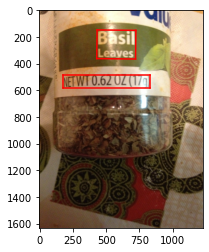

In [120]:
test_img_path = img_path + "/" + img_id + ".jpg"
img = Image.open(test_img_path)
plt.imshow(img)

for rect in new_rects:
    for i in range(4):
        x = [rect[i][0], rect[(i+1)%4][0]]
        y = [rect[i][1], rect[(i+1)%4][1]]
#         print(x, y)
        plt.plot(x, y, color="r")
        
plt.show()

In [110]:
new_texts

['A delicious CAFFEINE FREE HERB TEA']

In [127]:
angle

0.3109010705348838

In [128]:
rotate_rect(test_rect, angle, "S")

[(694.2440781546334, 748.4612425834705),
 (1044.012573019451, 748.4612425834705),
 (1044.7559218453666, 796.5387574165295),
 (695.2933436127526, 797.4908157204906)]

In [130]:
get_slope(rotate_rect(test_rect, angle))

0.0